In [ ]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta
import seaborn as sns
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)
!apt-get install tarfile
import tarfile
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import contextlib
import lzma
import tarfile
import matplotlib.pyplot as plt

!pip install visualkeras
import visualkeras

drive.mount('/content/drive')

os.chdir('drive/MyDrive/HDA')

from utilis import *

!tar -xf "speech_recognition.tar.xz" -C "/content"

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=8d165daedbec13b0a280410cee0485d64b8d762fda81c22b73ab2250754e7d32
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package tarfile
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content
/


**Preliminary Notes**

The code is divided in two blocks:
*   Analysis on standard dataset
*   Analysis on noisy dataset

Since the models are the same for each block, these are defined early in the notebook, as the early stopping criterion.
Each block have the same layout:

*   Model trainig
*   Training and validation curve
*   Model evalutaion on the test
*   Metrics calculation with confusion matrix

NB: all the notebook could be runned sequentially all at once, but I suggest to run it before with standard dataset, then reinitialize the session and run the analysis for noisy dataset, in order to not encounter any ram issue.



In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import keras

def CRNN_model(input_dimension, output_shape):

  X_input=keras.Input(input_dimension)

  X=tf.keras.layers.Conv2D(8, kernel_size=(1,3), dilation_rate=(1,2) , padding='same')(X_input)
  X=tf.keras.layers.Activation('relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Conv2D(1, kernel_size=(3,3), strides=(1,2) ,padding='same')(X)
  X=tf.keras.layers.Activation('relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Dropout(0.2)(X)

  X=tf.keras.layers.Lambda(lambda x:  tf.squeeze(x,-1))(X)

  X=tf.keras.layers.Permute(dims=(2,1))(X)

  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(X)
  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(X)

  X=tf.keras.layers.Dense(128, activation='relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Dropout(0.3)(X)

  X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

  model = Model(inputs = X_input, outputs = X_final, name='CRNN_base')

  return model

def RNN_base(input_dimension, output_shape):

  X_input=keras.Input(input_dimension)

  X=tf.keras.layers.Lambda(lambda x:  tf.squeeze(x,-1))(X_input)

  X=tf.keras.layers.Permute(dims=(2,1))(X)

  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(X)
  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(X)

  X=tf.keras.layers.Dense(128, activation='relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Dropout(0.4)(X)

  X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

  model = Model(inputs = X_input, outputs = X_final)

  return model

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import EarlyStopping, Callback

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.001)
clear_memory = ClearMemory()

callbacks = [early_stopping, clear_memory]

**Training Models with MFCC features**

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='mfcc')
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc')
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False  ,repeat=False, type='mfcc', testing=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

CRNN_m=CRNN_model(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CRNN_m.summary())

Model: "CRNN_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 39, 99, 8)         32        
                                                                 
 activation (Activation)     (None, 39, 99, 8)         0         
                                                                 
 batch_normalization (Batch  (None, 39, 99, 8)         32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 50, 1)         73        
                                                                 
 activation_1 (Activation)   (None, 39, 50, 1)         0         
                                                         

In [ ]:
CRNN_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CRNN_m=CRNN_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 521s 446ms/step - loss: 2.1759 - sparse_categorical_accuracy: 0.4127 - val_loss: 1.0311 - val_sparse_categorical_accuracy: 0.7116
Epoch 2/25
497/497 [==============================] - 91s 183ms/step - loss: 0.7572 - sparse_categorical_accuracy: 0.7830 - val_loss: 0.5398 - val_sparse_categorical_accuracy: 0.8418
Epoch 3/25
497/497 [==============================] - 88s 177ms/step - loss: 0.5312 - sparse_categorical_accuracy: 0.8452 - val_loss: 0.4663 - val_sparse_categorical_accuracy: 0.8612
Epoch 4/25
497/497 [==============================] - 89s 180ms/step - loss: 0.4518 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.4070 - val_sparse_categorical_accuracy: 0.8784
Epoch 5/25
497/497 [==============================] - 92s 185ms/step - loss: 0.3940 - sparse_categorical_accuracy: 0.8836 - val_loss: 0.3398 - val_sparse_categorical_accuracy: 0.8994
Epoch 6/25
497/497 [==============================] - 89s 179ms/step - loss: 0.3600 

In [ ]:
CRNN_m.save("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('CRNN_mfcc'))
#CRNN_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('CRNN_mfcc'))

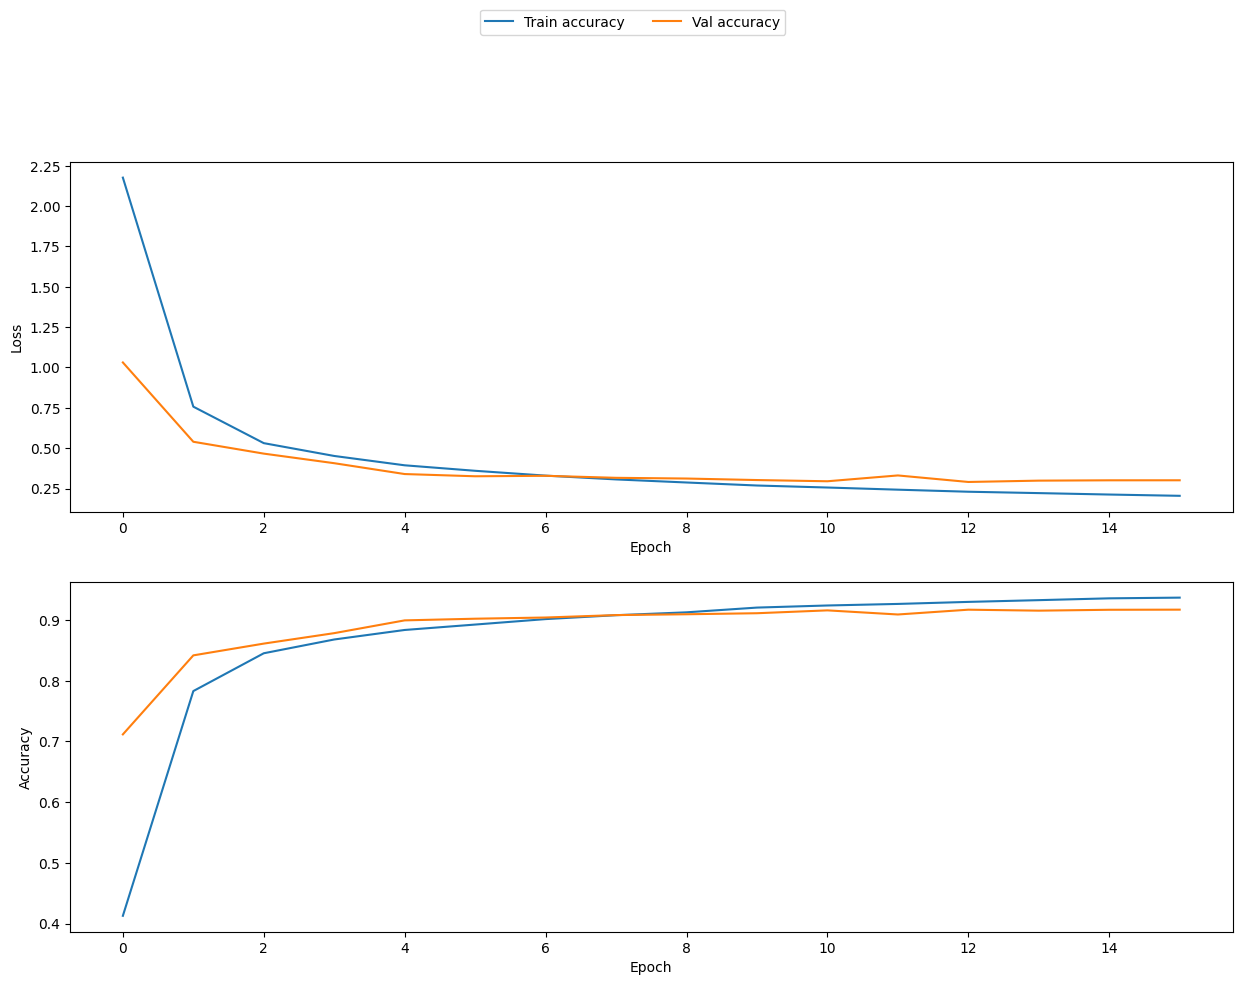

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CRNN_m.history['loss'], label='Train loss')
axis[0].plot(history_CRNN_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CRNN_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CRNN_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=CRNN_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CRNN_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 126s 757ms/step


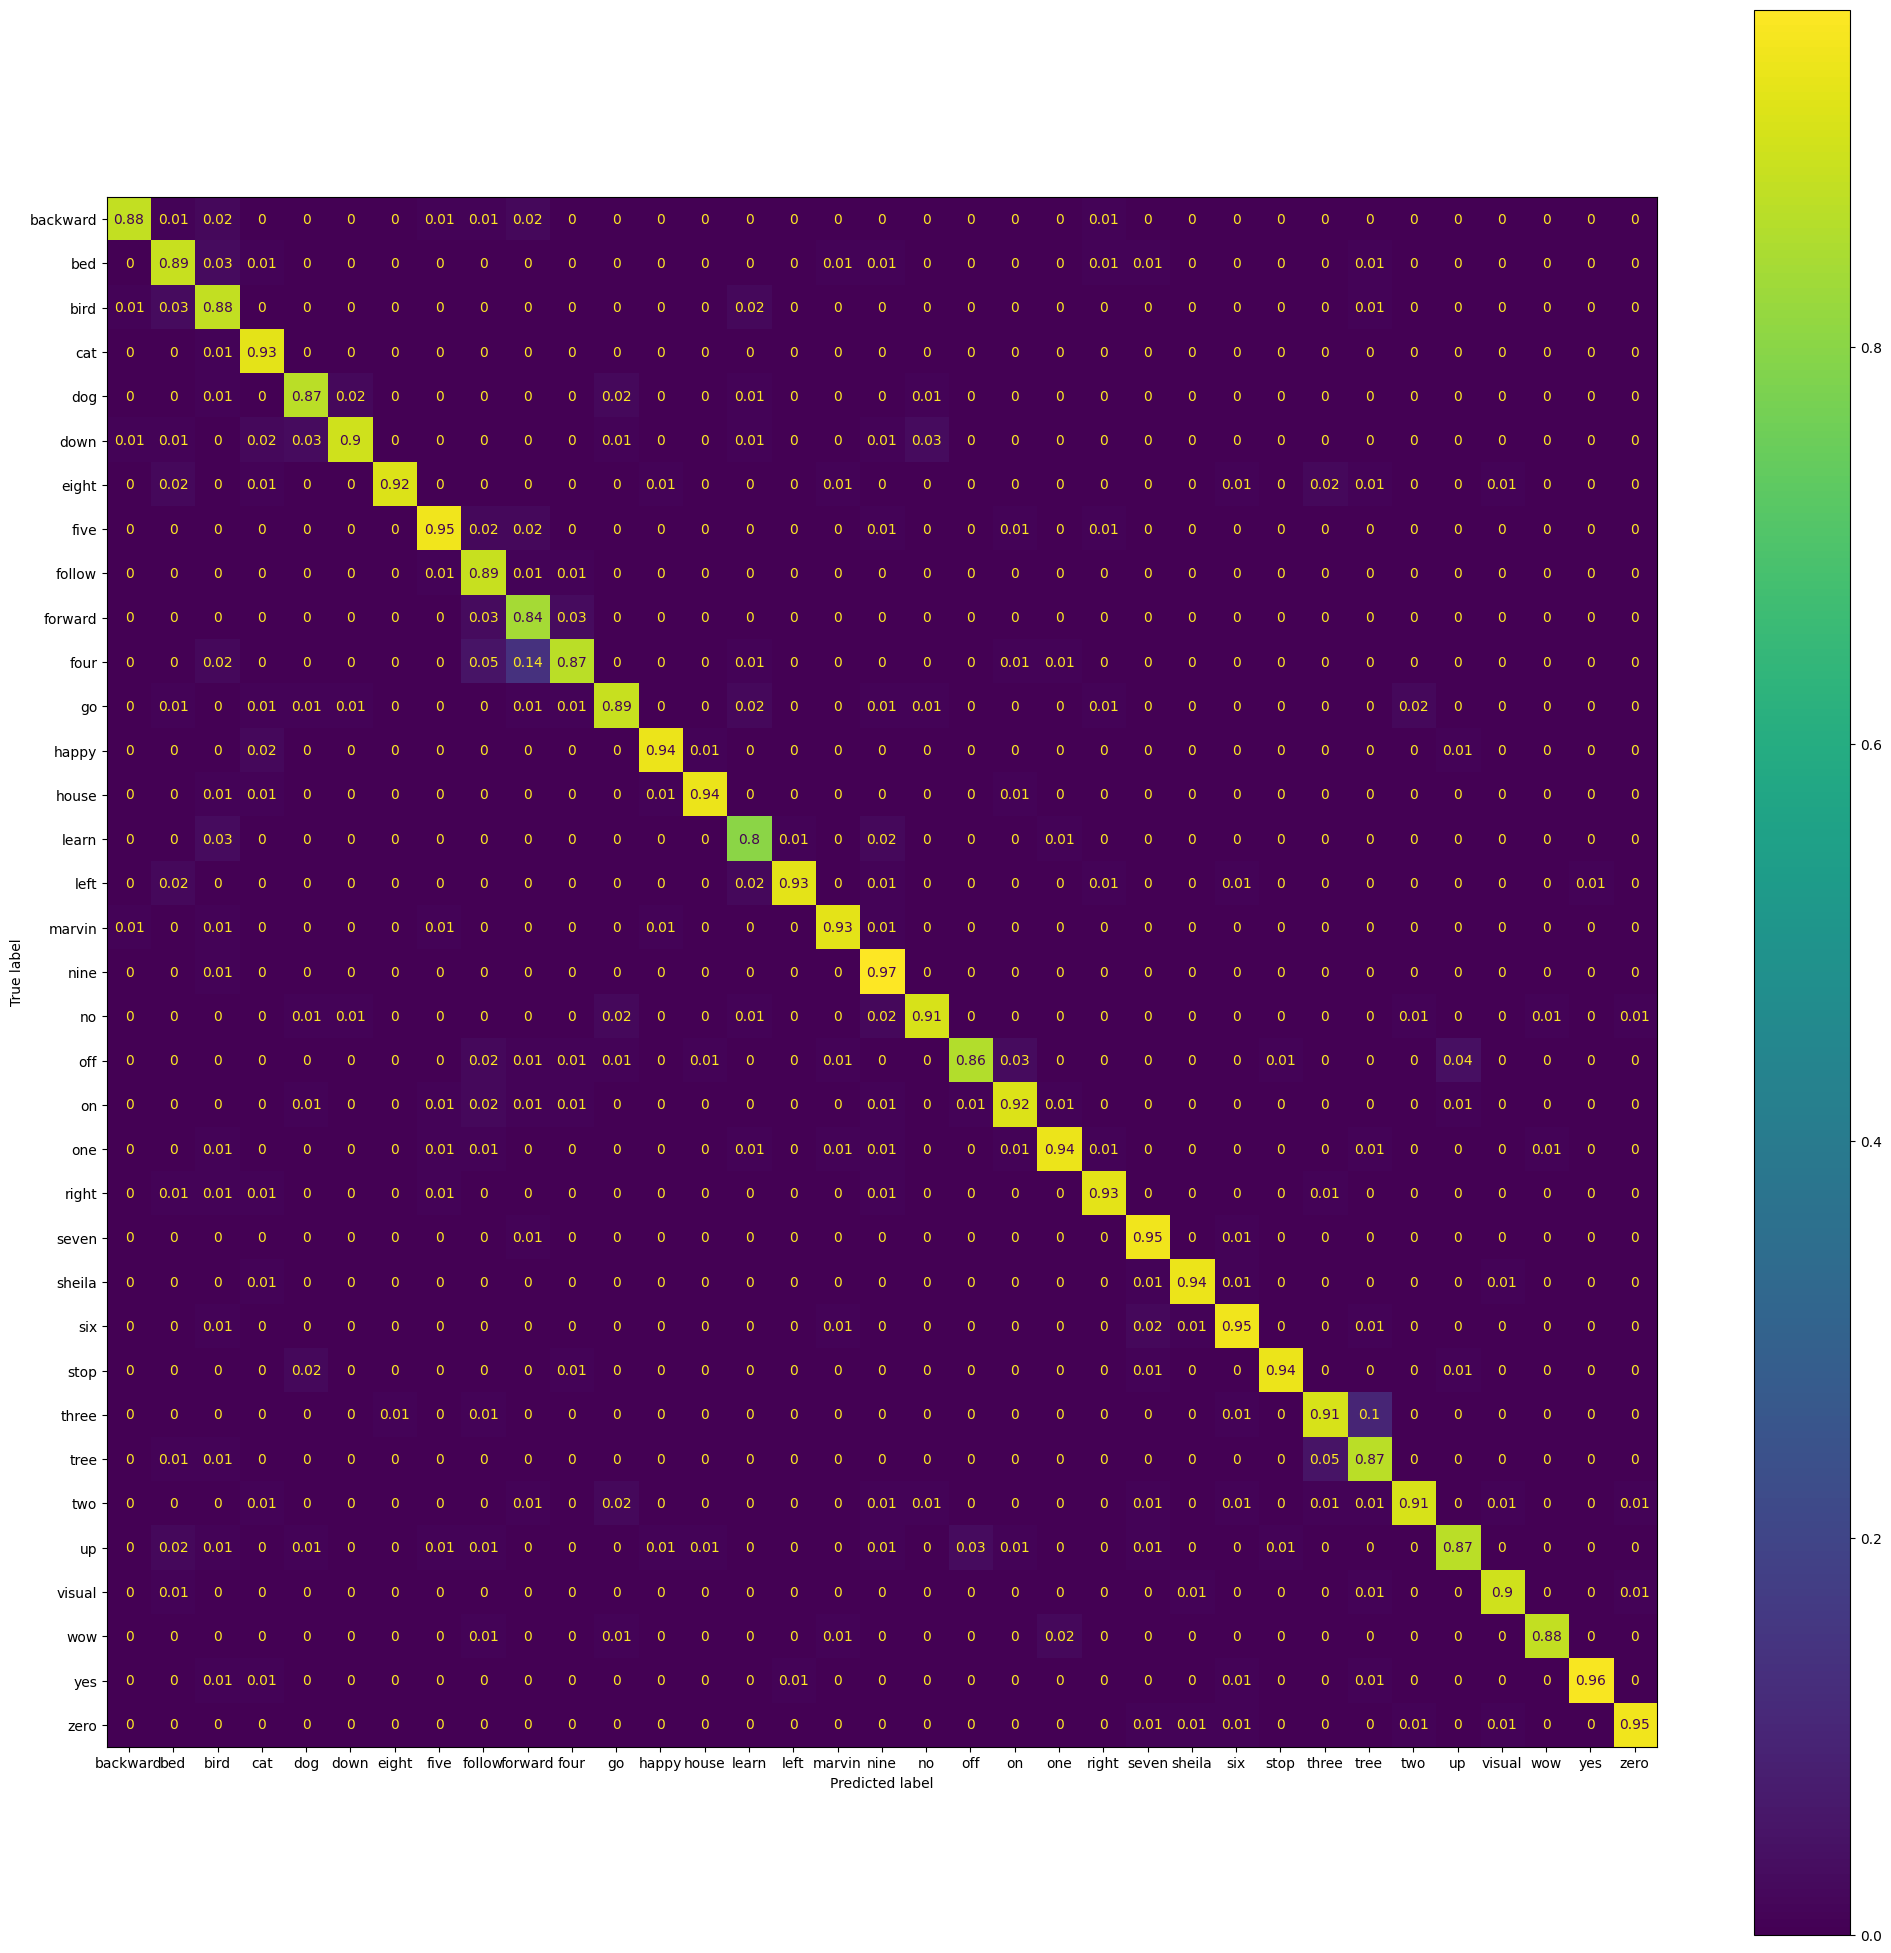

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.915009,0.90904,0.91516,0.915009,0.908867,0.916445,0.915009,0.909924,0.915009,0.915009,0.90904,CRNN_m


In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

RNN_base=RNN_base(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(RNN_base.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39, 99, 1)]       0         
                                                                 
 lambda (Lambda)             (None, 39, 99)            0         
                                                                 
 permute (Permute)           (None, 99, 39)            0         
                                                                 
 bidirectional (Bidirection  (None, 99, 128)           40320     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16512 

In [ ]:
RNN_base.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_RNN_base=RNN_base.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 82s 163ms/step - loss: 2.8749 - sparse_categorical_accuracy: 0.2511 - val_loss: 1.2640 - val_sparse_categorical_accuracy: 0.6372
Epoch 2/25
497/497 [==============================] - 81s 162ms/step - loss: 0.9647 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.6632 - val_sparse_categorical_accuracy: 0.8089
Epoch 3/25
497/497 [==============================] - 81s 163ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.8176 - val_loss: 0.5241 - val_sparse_categorical_accuracy: 0.8449
Epoch 4/25
497/497 [==============================] - 78s 157ms/step - loss: 0.4966 - sparse_categorical_accuracy: 0.8541 - val_loss: 0.4686 - val_sparse_categorical_accuracy: 0.8624
Epoch 5/25
497/497 [==============================] - 79s 159ms/step - loss: 0.4281 - sparse_categorical_accuracy: 0.8732 - val_loss: 0.4322 - val_sparse_categorical_accuracy: 0.8722
Epoch 6/25
497/497 [==============================] - 79s 159ms/step - loss: 0.3792 -

In [ ]:
RNN_base.save("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('RNN_base_mfcc'))
#RNN_base=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('RNN_base_mfcc'))

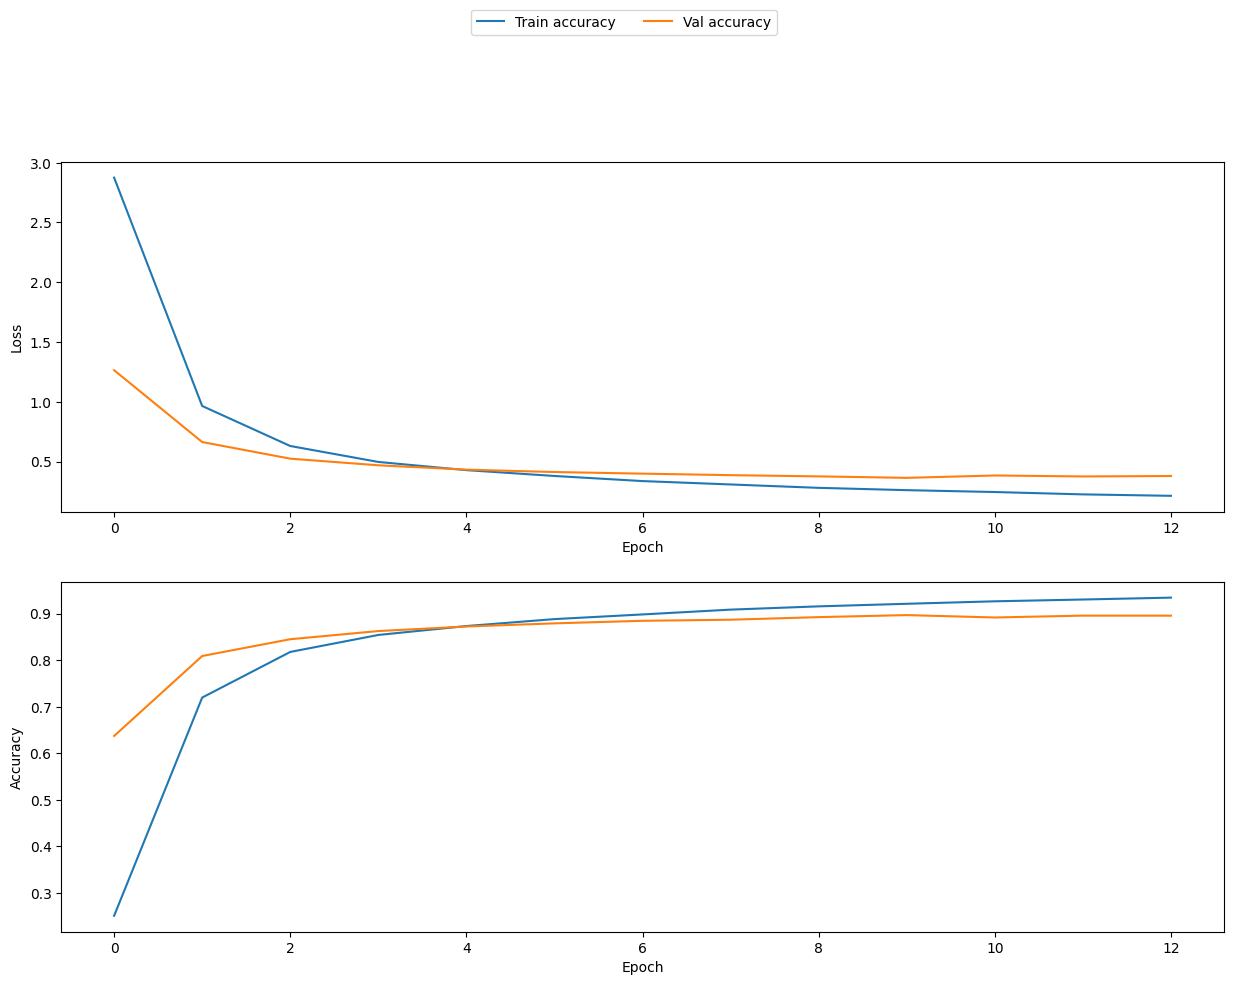

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_RNN_base.history['loss'], label='Train loss')
axis[0].plot(history_RNN_base.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_RNN_base.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_RNN_base.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


pred=RNN_base.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{RNN_base=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 6s 35ms/step


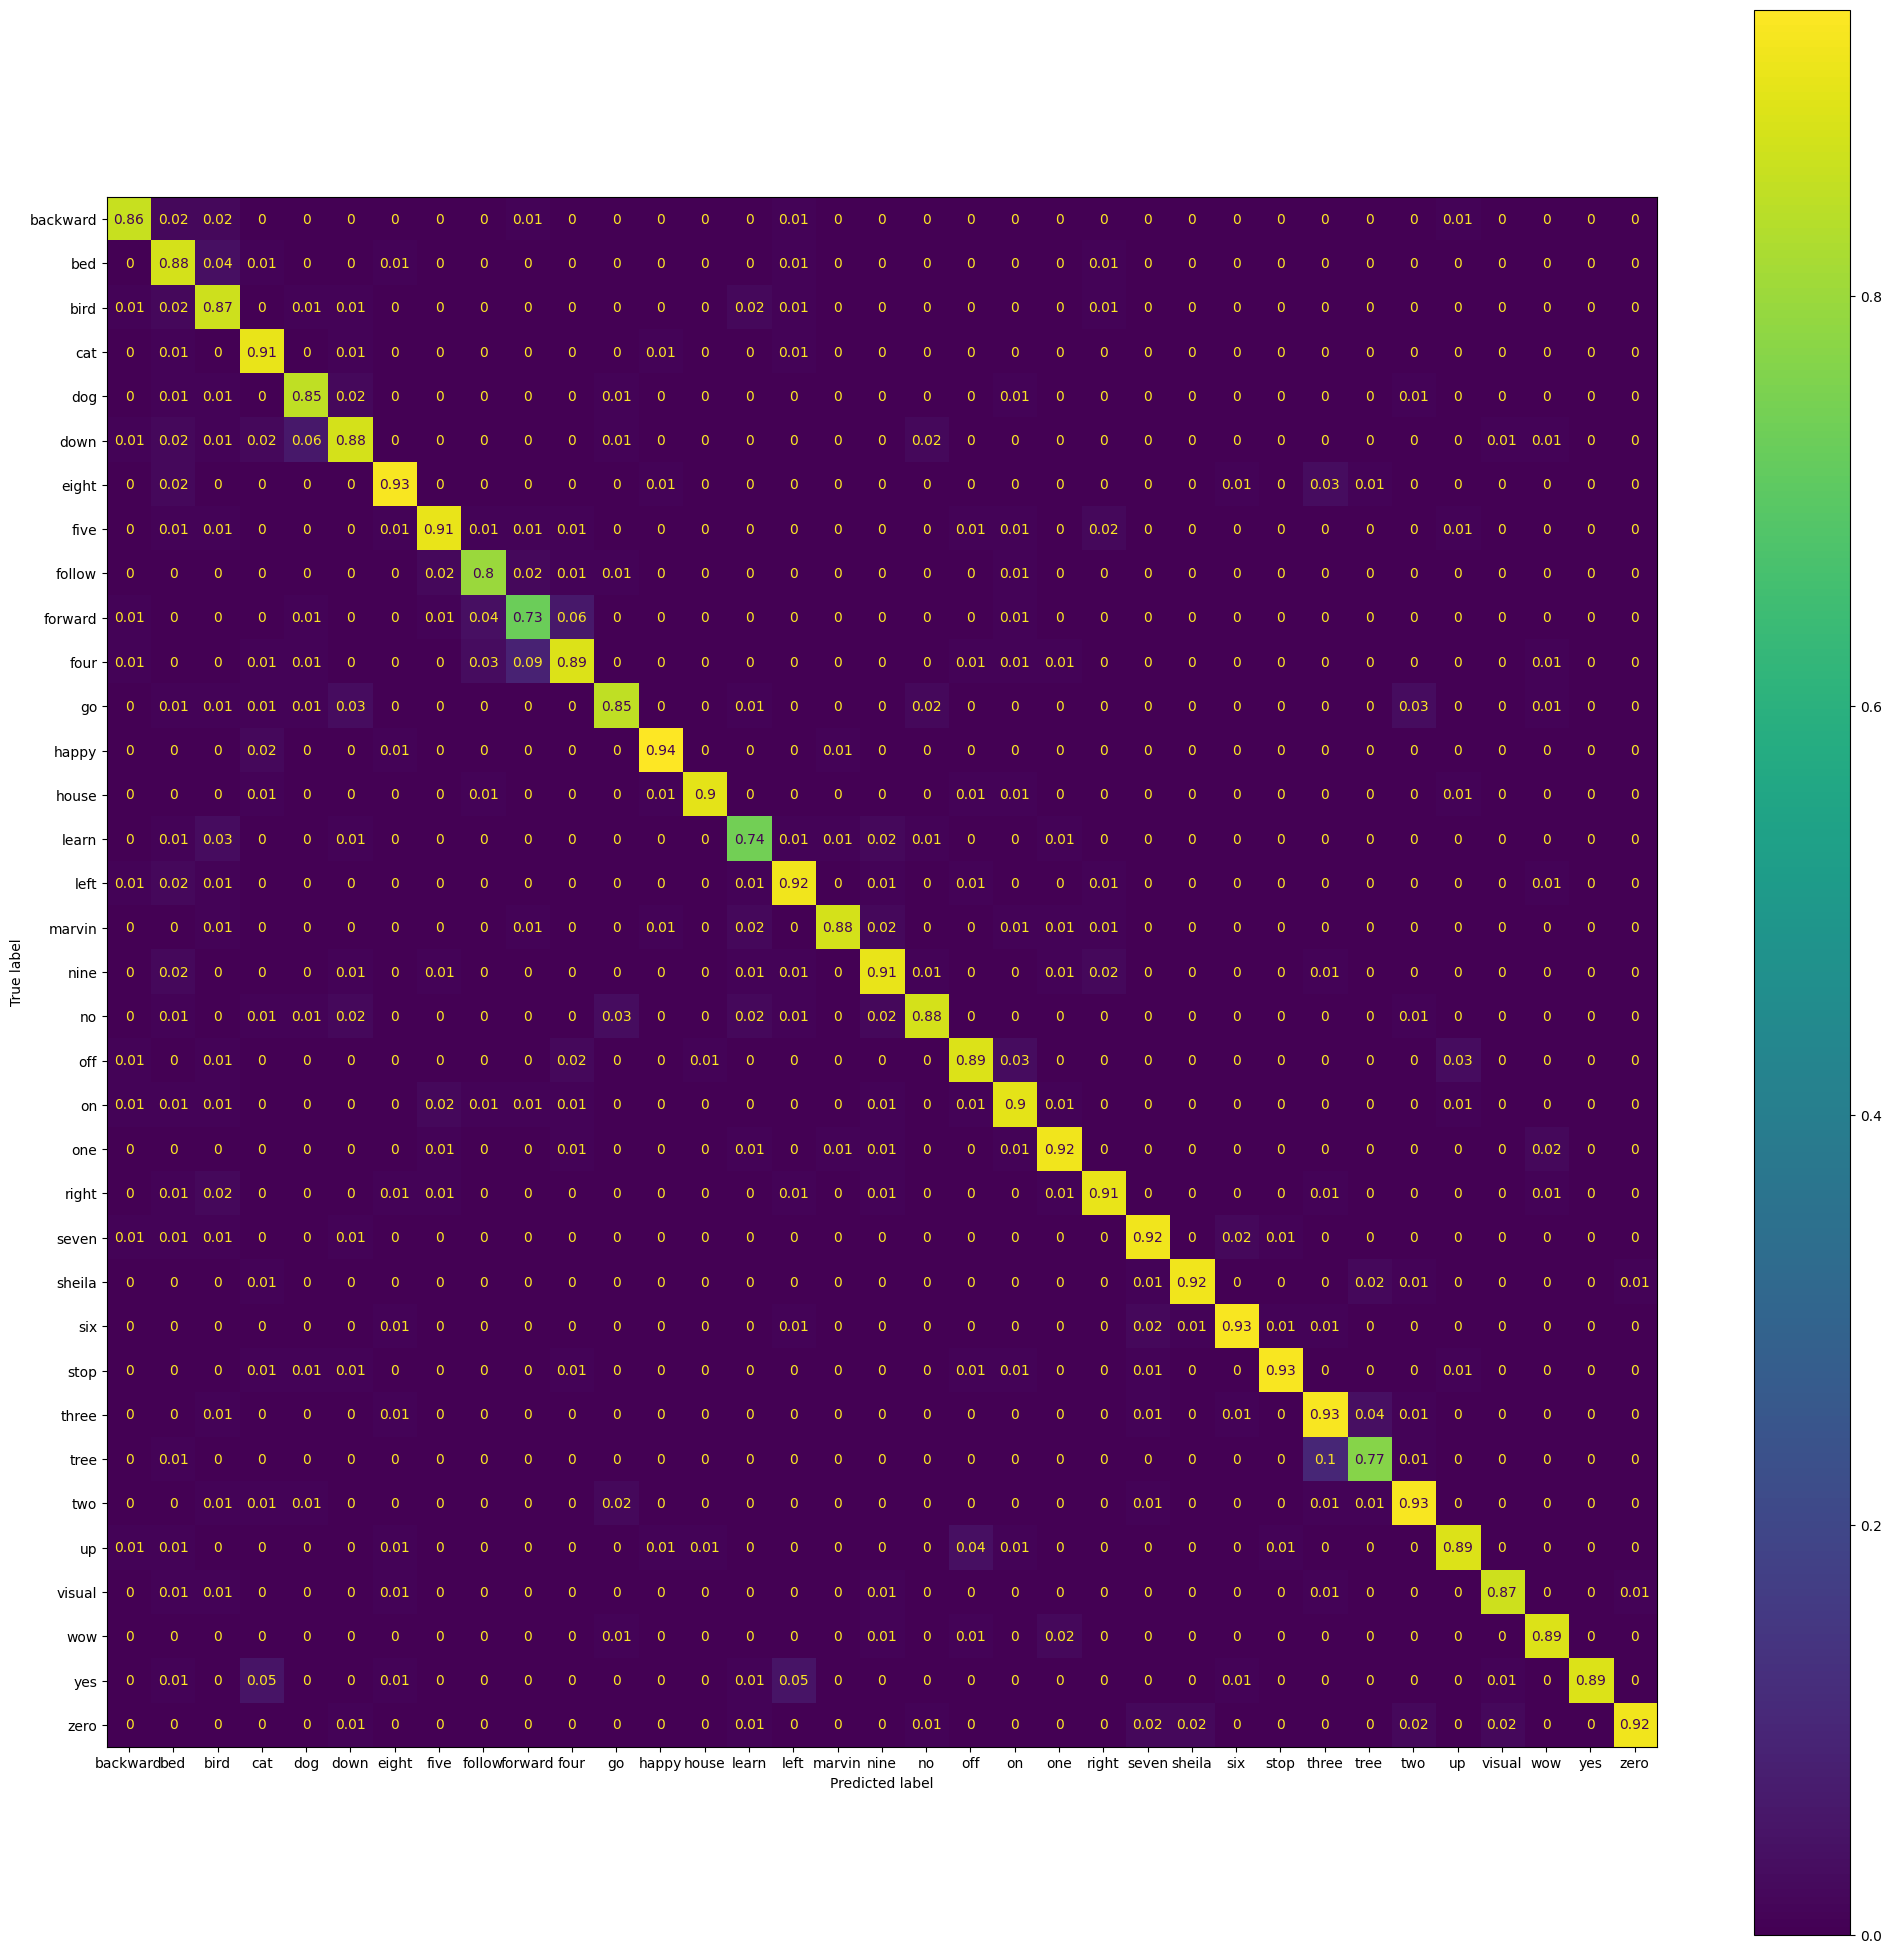

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.915009,0.909040,0.915160,0.915009,0.908867,0.916445,0.915009,0.909924,0.915009,0.915009,0.909040,CRNN_m
1,0.893750,0.883322,0.893805,0.893750,0.886812,0.895346,0.893750,0.892185,0.893750,0.893750,0.883322,RNN_base


**ANALYSIS ON NOISY DATASET**

In [ ]:
del perform, train_set, train_set_label, validation_set, validation_set_label, test_set, test_set_label,
del history_RNN_base, RNN_base, CRNN_m, history_CRNN_m

tf.keras.backend.clear_session()
gc.collect()


180

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.2)

#df.to_csv("content/drive/MyDrive/HDA/training_validation_test.csv")

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size, shuffle=True, cache_file_value='train_cache', type='mfcc', input_noise=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc', input_noise=True)
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False, repeat=False, type='mfcc', testing=True, input_noise=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

CRNN_m=CRNN_model(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CRNN_m.summary())

Model: "CRNN_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 39, 99, 8)         32        
                                                                 
 activation (Activation)     (None, 39, 99, 8)         0         
                                                                 
 batch_normalization (Batch  (None, 39, 99, 8)         32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 50, 1)         73        
                                                                 
 activation_1 (Activation)   (None, 39, 50, 1)         0         
                                                         

In [ ]:
CRNN_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CRNN_m=CRNN_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 89s 177ms/step - loss: 2.4544 - sparse_categorical_accuracy: 0.3116 - val_loss: 1.5445 - val_sparse_categorical_accuracy: 0.5390
Epoch 2/25
497/497 [==============================] - 88s 177ms/step - loss: 1.2904 - sparse_categorical_accuracy: 0.6182 - val_loss: 1.0574 - val_sparse_categorical_accuracy: 0.6865
Epoch 3/25
497/497 [==============================] - 85s 171ms/step - loss: 1.0472 - sparse_categorical_accuracy: 0.6901 - val_loss: 0.8796 - val_sparse_categorical_accuracy: 0.7402
Epoch 4/25
497/497 [==============================] - 85s 171ms/step - loss: 0.9234 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.9183 - val_sparse_categorical_accuracy: 0.7259
Epoch 5/25
497/497 [==============================] - 89s 178ms/step - loss: 0.8487 - sparse_categorical_accuracy: 0.7467 - val_loss: 0.8417 - val_sparse_categorical_accuracy: 0.7497
Epoch 6/25
497/497 [==============================] - 88s 176ms/step - loss: 0.7920 -

In [ ]:
CRNN_m.save("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('CRNN_mfcc_noise'))
#mix_CNN_flog=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/{}".format('CRNN_log_f'))

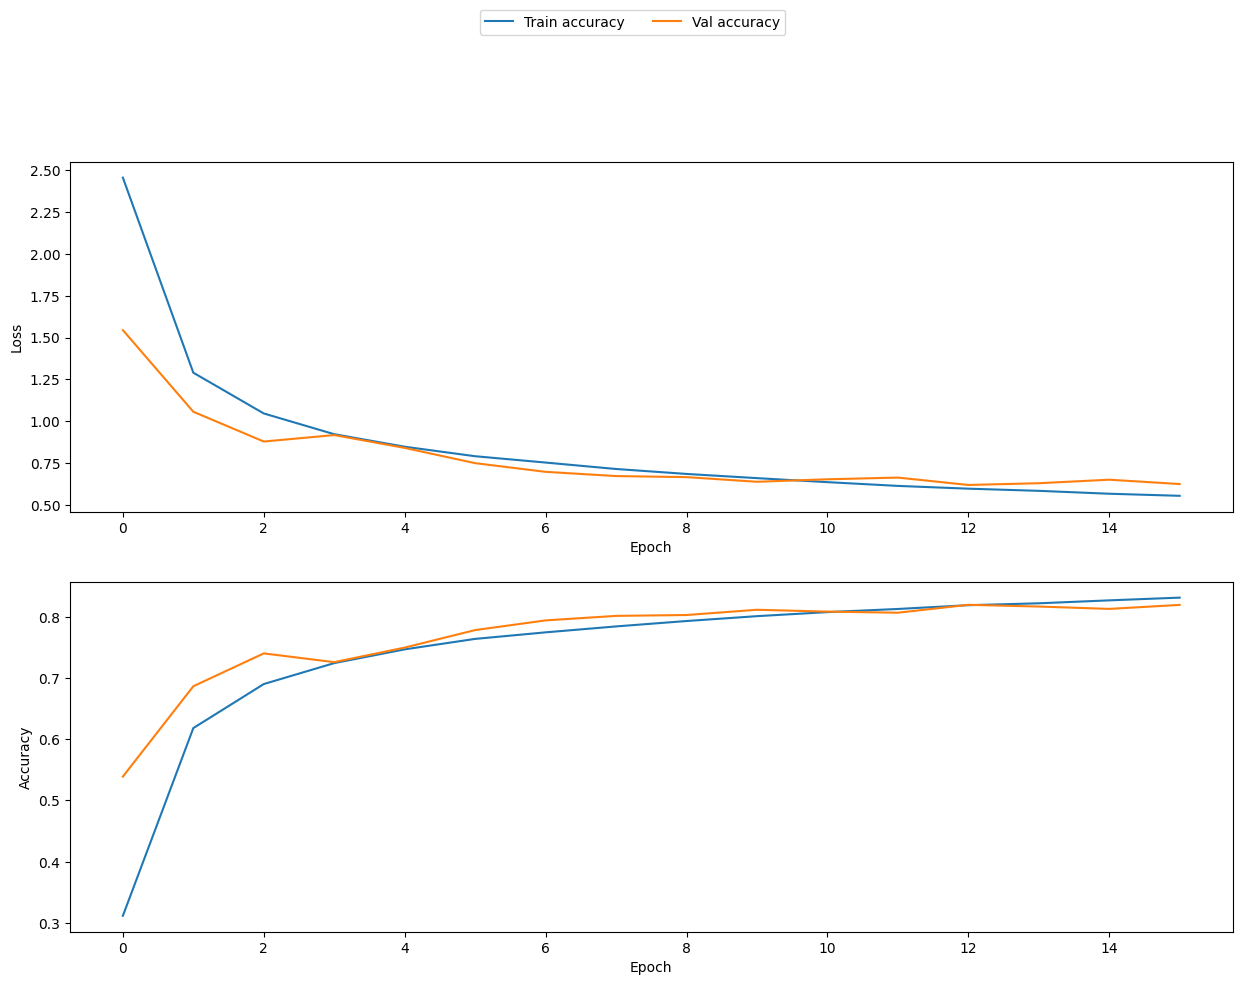

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CRNN_m.history['loss'], label='Train loss')
axis[0].plot(history_CRNN_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CRNN_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CRNN_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=CRNN_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CRNN_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 8s 48ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.805357,0.795843,0.805572,0.805357,0.798879,0.811163,0.805357,0.808369,0.805357,0.805357,0.795843,CRNN_m


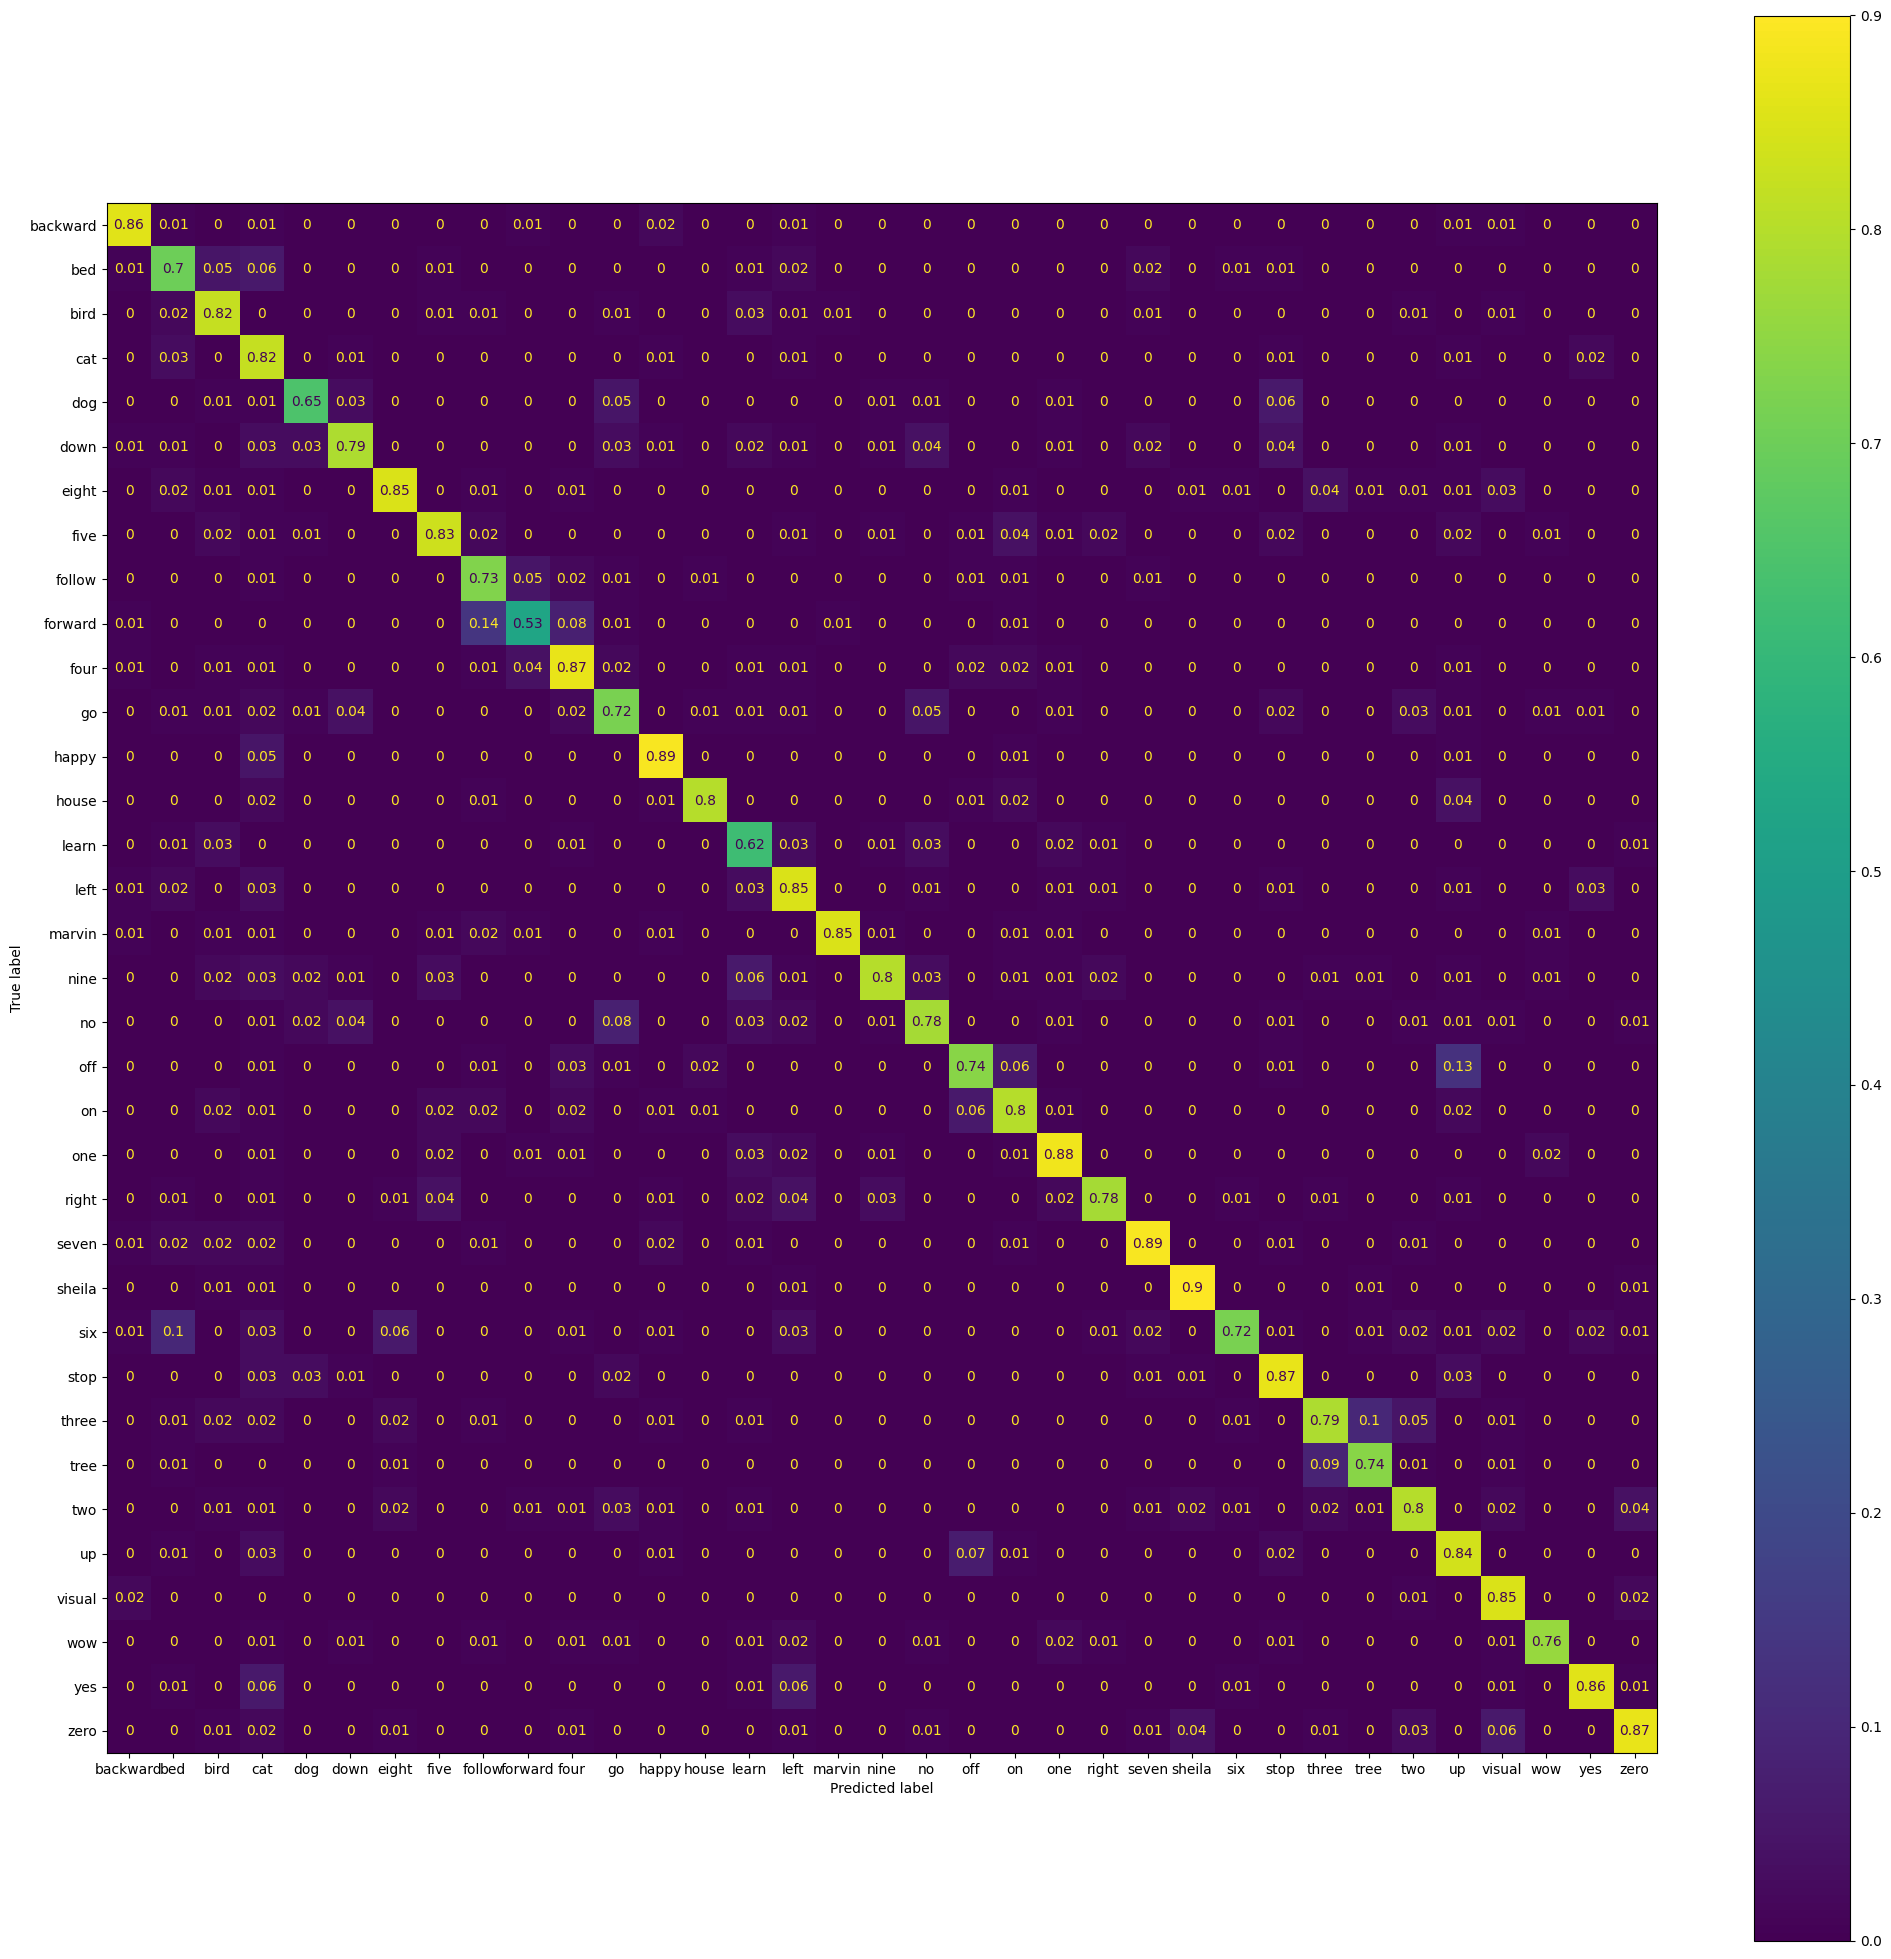

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

RNN_base=RNN_base(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(RNN_base.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39, 99, 1)]       0         
                                                                 
 lambda (Lambda)             (None, 39, 99)            0         
                                                                 
 permute (Permute)           (None, 99, 39)            0         
                                                                 
 bidirectional (Bidirection  (None, 99, 128)           40320     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16512 

In [ ]:
RNN_base.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_RNN_base=RNN_base.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 73s 144ms/step - loss: 2.3446 - sparse_categorical_accuracy: 0.3313 - val_loss: 1.9735 - val_sparse_categorical_accuracy: 0.4291
Epoch 2/25
497/497 [==============================] - 74s 149ms/step - loss: 1.4468 - sparse_categorical_accuracy: 0.5705 - val_loss: 1.3355 - val_sparse_categorical_accuracy: 0.6062
Epoch 3/25
497/497 [==============================] - 74s 148ms/step - loss: 1.1732 - sparse_categorical_accuracy: 0.6517 - val_loss: 1.0518 - val_sparse_categorical_accuracy: 0.6913
Epoch 4/25
497/497 [==============================] - 75s 150ms/step - loss: 1.0063 - sparse_categorical_accuracy: 0.7040 - val_loss: 1.0271 - val_sparse_categorical_accuracy: 0.6958
Epoch 5/25
497/497 [==============================] - 74s 149ms/step - loss: 0.9122 - sparse_categorical_accuracy: 0.7302 - val_loss: 0.8952 - val_sparse_categorical_accuracy: 0.7345
Epoch 6/25
497/497 [==============================] - 70s 142ms/step - loss: 0.8343 -

In [ ]:
RNN_base.save("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('RNN_base_mfcc_noisy'))
#RNN_base=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('RNN_base_mfcc_noisy'))

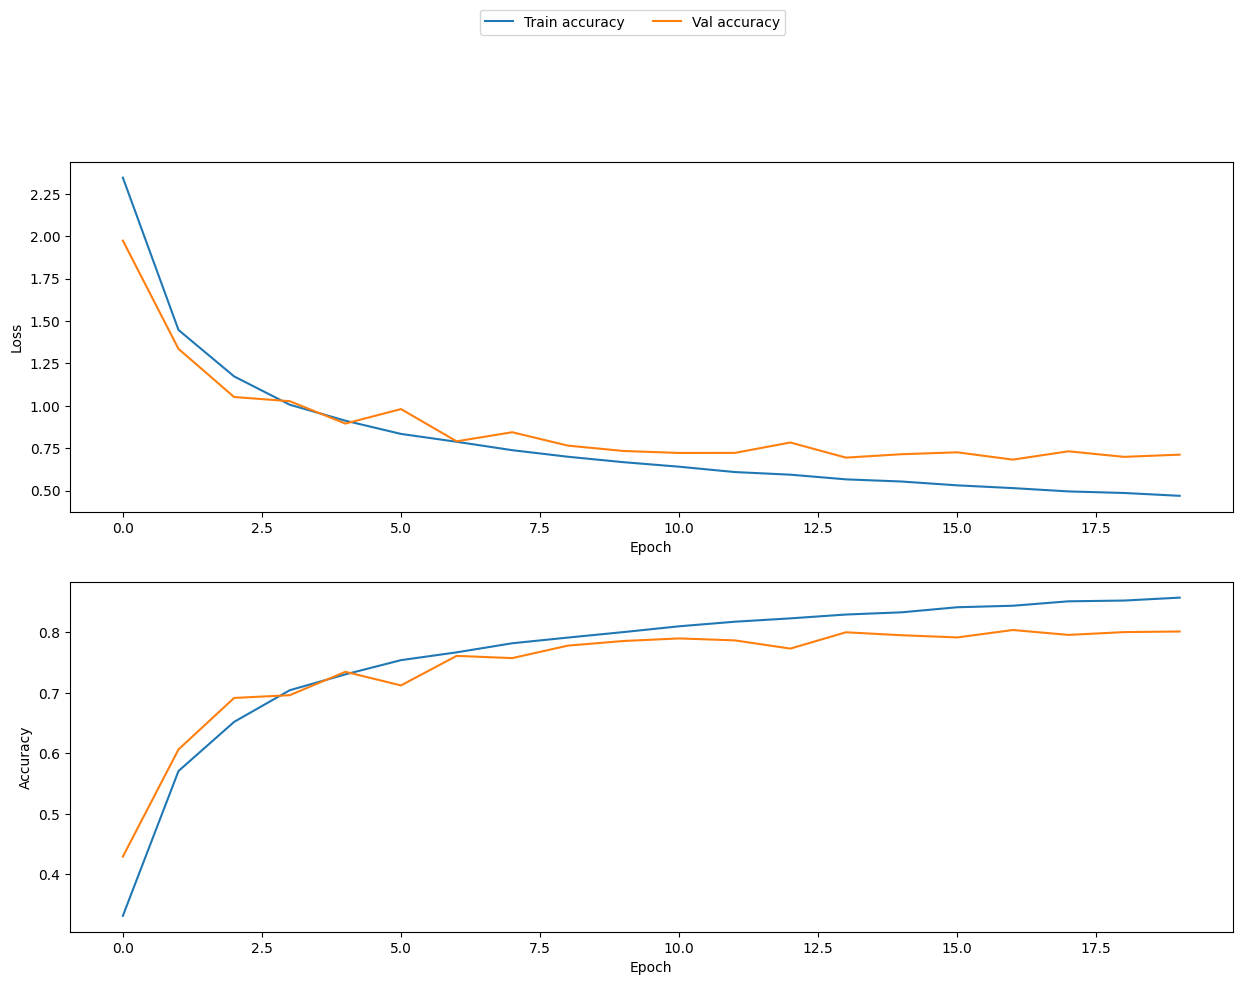

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_RNN_base.history['loss'], label='Train loss')
axis[0].plot(history_RNN_base.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_RNN_base.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_RNN_base.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


pred=RNN_base.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{RNN_base=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 6s 37ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.816885,0.807881,0.818281,0.816885,0.811654,0.824664,0.816885,0.821942,0.816885,0.816885,0.807881,CRNN_m
1,0.801861,0.787781,0.801828,0.801861,0.795824,0.809357,0.801861,0.812231,0.801861,0.801861,0.787781,RNN_base
